In [6]:
# 1) Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install duckdb
import duckdb #for sql

   ---------------------------------------- 0.0/11.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.4 MB ? eta -:--:--
    --------------------------------------- 0.3/11.4 MB ? eta -:--:--
    --------------------------------------- 0.3/11.4 MB ? eta -:--:--
   - -------------------------------------- 0.5/11.4 MB 649.7 kB/s eta 0:00:17
   -- ------------------------------------- 0.8/11.4 MB 709.7 kB/s eta 0:00:15
   -- ------------------------------------- 0.8/11.4 MB 709.7 kB/s eta 0:00:15
   -- ------------------------------------- 0.8/11.4 MB 709.7 kB/s eta 0:00:15
   --- ------------------------------------ 1.0/11.4 MB 545.1 kB/s eta 0:00:19
   --- ------------------------------------ 1.0/11.4 MB 545.1 kB/s eta 0:00:19
   --- ------------------------------------ 1.0/11.4 MB 545.1 kB/s eta 0:00:19
   ---- -------------------

In [13]:
train = pd.read_csv('train.csv')
features = pd.read_csv('features.csv')
stores = pd.read_csv('stores.csv')
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [14]:
# Function for quick report
def quick_report(df, name):
    print(f"\n=== {name} ===")
    print("Shape:", df.shape)   # rows x columns
    print("Columns:", df.columns.tolist())
    print("Missing values (%):")
    print(df.isna().mean().round(4) * 100)  # % missing
    print("Data types:")
    print(df.dtypes)

# Run for all three
quick_report(train, "TRAIN")
quick_report(features, "FEATURES")
quick_report(stores, "STORES")


=== TRAIN ===
Shape: (421570, 5)
Columns: ['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday']
Missing values (%):
Store           0.0
Dept            0.0
Date            0.0
Weekly_Sales    0.0
IsHoliday       0.0
dtype: float64
Data types:
Store             int64
Dept              int64
Date             object
Weekly_Sales    float64
IsHoliday          bool
dtype: object

=== FEATURES ===
Shape: (8190, 12)
Columns: ['Store', 'Date', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'IsHoliday']
Missing values (%):
Store            0.00
Date             0.00
Temperature      0.00
Fuel_Price       0.00
MarkDown1       50.77
MarkDown2       64.33
MarkDown3       55.89
MarkDown4       57.70
MarkDown5       50.55
CPI              7.14
Unemployment     7.14
IsHoliday        0.00
dtype: float64
Data types:
Store             int64
Date             object
Temperature     float64
Fuel_Price      float64
MarkDown1       float

In [15]:
# TRAIN dataset duplicates?
dups = train.duplicated(subset=["Store","Dept","Date"]).sum()
print("Duplicate rows (Store, Dept, Date):", dups)

# Sales values ka range
print("Min Weekly Sales:", train["Weekly_Sales"].min())
print("Max Weekly Sales:", train["Weekly_Sales"].max())

Duplicate rows (Store, Dept, Date): 0
Min Weekly Sales: -4988.94
Max Weekly Sales: 693099.36


In [16]:
train["Date"] = pd.to_datetime(train["Date"])
features["Date"] = pd.to_datetime(features["Date"])

In [19]:
# Fill markdowns with 0
markdown_cols = ["MarkDown1","MarkDown2","MarkDown3","MarkDown4","MarkDown5"]
for col in markdown_cols:
    features[col] = features[col].fillna(0)

# CPI & Unemployment: forward fill/backward fill per store
# CPI & Unemployment: forward fill + backward fill (per store)
features["CPI"] = features.groupby("Store")["CPI"].transform(lambda x: x.ffill().bfill())
features["Unemployment"] = features.groupby("Store")["Unemployment"].transform(lambda x: x.ffill().bfill())

In [20]:
features.isna().sum()

Store           0
Date            0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
IsHoliday       0
dtype: int64

In [21]:
# Merge train with features
merged = pd.merge(train, features, on=["Store", "Date", "IsHoliday"], how="left")

# Merge with stores data
merged = pd.merge(merged, stores, on="Store", how="left")

print("Final merged shape:", merged.shape)
merged.head()

Final merged shape: (421570, 16)


,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,A,151315


In [22]:
# Check nulls again
print(merged.isna().sum())

# Date range
print("Date range:", merged["Date"].min(), "to", merged["Date"].max())

# Unique counts
print("Stores:", merged["Store"].nunique())
print("Departments:", merged["Dept"].nunique())


Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Type            0
Size            0
dtype: int64
Date range: 2010-02-05 00:00:00 to 2012-10-26 00:00:00
Stores: 45
Departments: 81


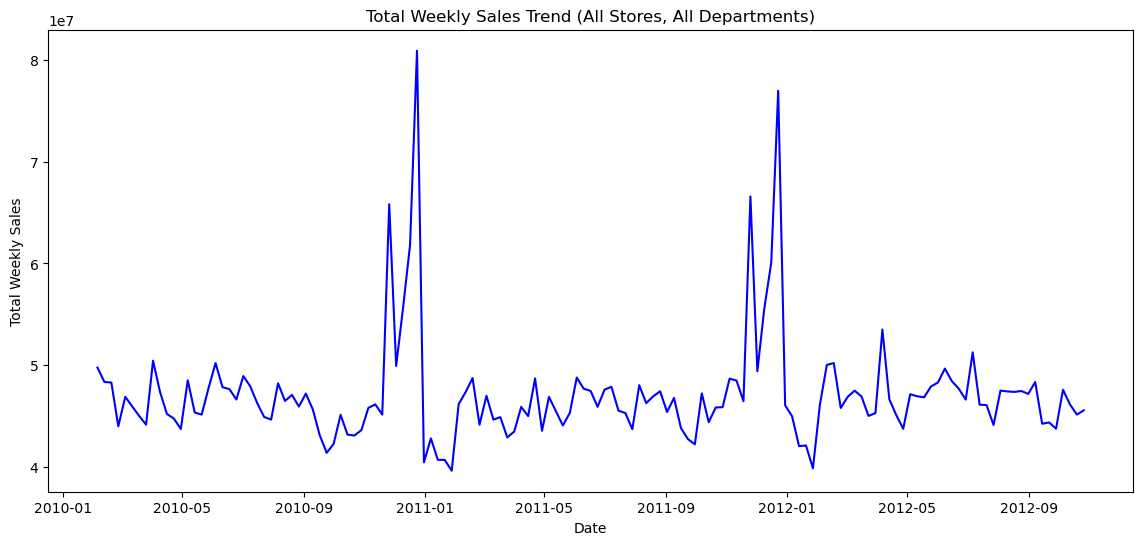

<Figure size 640x480 with 0 Axes>

In [26]:
import matplotlib.pyplot as plt

sales_trend = merged.groupby("Date")["Weekly_Sales"].sum()

plt.figure(figsize=(14,6))
plt.plot(sales_trend.index, sales_trend.values, color="blue")
plt.title("Total Weekly Sales Trend (All Stores, All Departments)")
plt.xlabel("Date")
plt.ylabel("Total Weekly Sales")
plt.show()

IsHoliday
False    15901.445069
True     17035.823187
Name: Weekly_Sales, dtype: float64


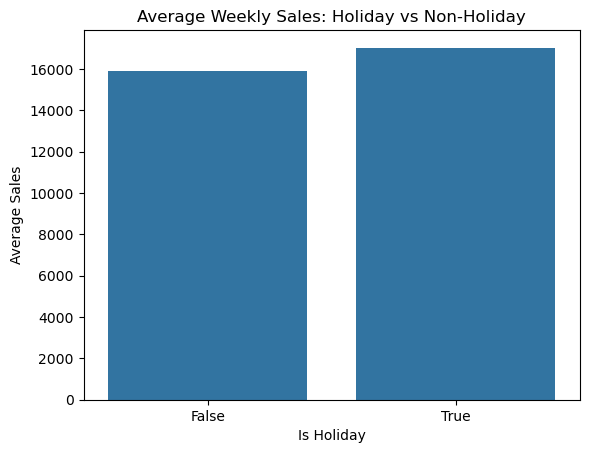

In [28]:
import seaborn as sns
holiday_sales = merged.groupby("IsHoliday")["Weekly_Sales"].mean()
print(holiday_sales)

sns.barplot(x=holiday_sales.index, y=holiday_sales.values)
plt.title("Average Weekly Sales: Holiday vs Non-Holiday")
plt.xlabel("Is Holiday")
plt.ylabel("Average Sales")
plt.show()

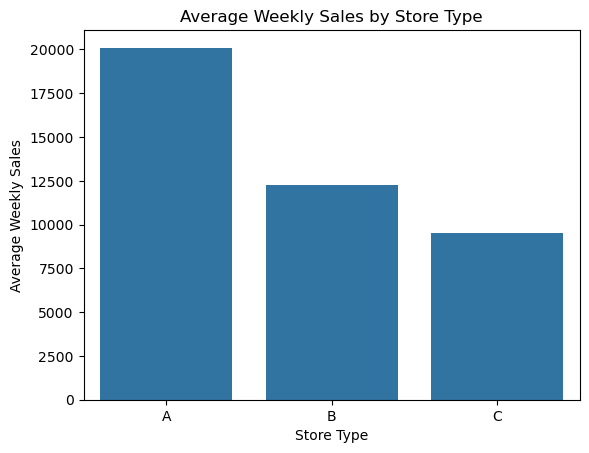

In [29]:
store_sales = merged.groupby("Type")["Weekly_Sales"].mean()

sns.barplot(x=store_sales.index, y=store_sales.values)
plt.title("Average Weekly Sales by Store Type")
plt.xlabel("Store Type")
plt.ylabel("Average Weekly Sales")
plt.show()

In [30]:
# Sort by Date
merged = merged.sort_values("Date")

# Train = data before 2012
train_df = merged[merged["Date"] < "2012-01-01"]
test_df  = merged[merged["Date"] >= "2012-01-01"]

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Train shape: (294132, 16)
Test shape: (127438, 16)


In [32]:
# Create lag feature
merged["lag_1"] = merged.groupby(["Store","Dept"])["Weekly_Sales"].shift(1)

# Only use test set for evaluation
test_df = merged[merged["Date"] >= "2012-01-01"].copy()

# Predictions = lag_1 (previous week sales)
test_df["y_pred"] = test_df["lag_1"]

In [36]:
# Remove rows where lag_1 is NaN
test_eval = test_df.dropna(subset=["y_pred"]).copy()

from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

rmse = np.sqrt(mean_squared_error(test_eval["Weekly_Sales"], test_eval["y_pred"]))
mae  = mean_absolute_error(test_eval["Weekly_Sales"], test_eval["y_pred"])
# Avoid divide by zero for MAPE
mask = test_eval["Weekly_Sales"] != 0
mape = np.mean(np.abs((test_eval.loc[mask, "Weekly_Sales"] - test_eval.loc[mask, "y_pred"]) / test_eval.loc[mask, "Weekly_Sales"])) * 100

print("Naive Forecast Performance:")
print("RMSE:", rmse)
print("MAE:", mae)
print("MAPE (%):", mape)

Naive Forecast Performance:
RMSE: 3940.7162790856532
MAE: 1717.046373333124
MAPE (%): 270.1566115101317


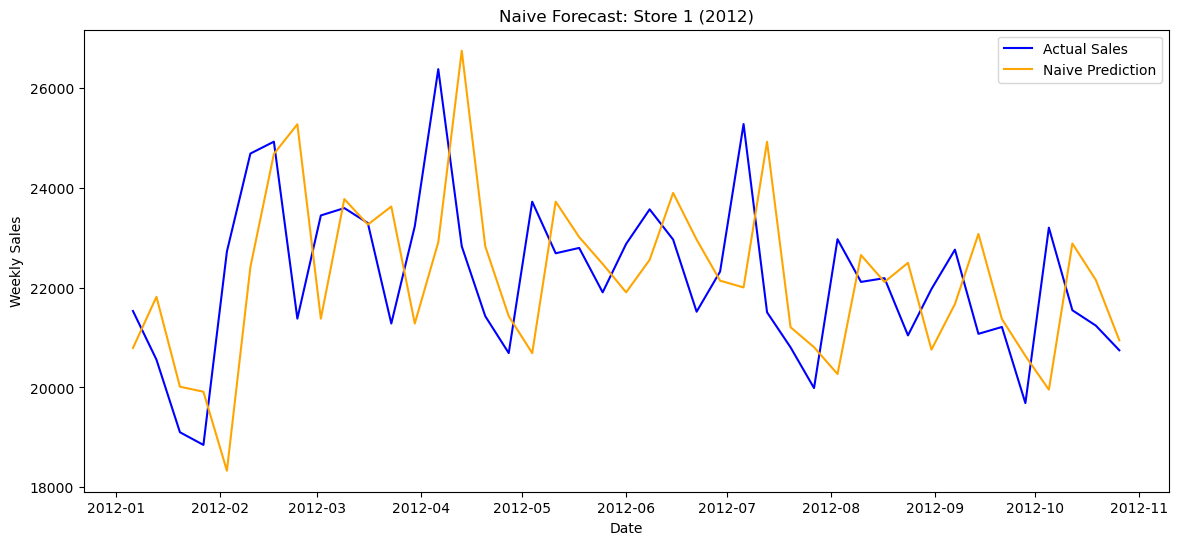

In [37]:
sample = test_df[test_df["Store"]==1].groupby("Date")[["Weekly_Sales","y_pred"]].mean()

plt.figure(figsize=(14,6))
plt.plot(sample.index, sample["Weekly_Sales"], label="Actual Sales", color="blue")
plt.plot(sample.index, sample["y_pred"], label="Naive Prediction", color="orange")
plt.title("Naive Forecast: Store 1 (2012)")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend()
plt.show()

In [39]:
# Feature engineering
merged["Year"] = merged["Date"].dt.year
merged["Month"] = merged["Date"].dt.month
merged["Week"] = merged["Date"].dt.isocalendar().week.astype(int)

# Lag features
merged["lag_1"] = merged.groupby(["Store","Dept"])["Weekly_Sales"].shift(1)
merged["lag_2"] = merged.groupby(["Store","Dept"])["Weekly_Sales"].shift(2)
merged["ma_4"]  = merged.groupby(["Store","Dept"])["Weekly_Sales"].shift(1).rolling(4).mean()


In [40]:
# Drop NaN (jo lag/ma ki wajah se aaye)
model_df = merged.dropna().copy()

train_rf = model_df[model_df["Date"] < "2012-01-01"]
test_rf  = model_df[model_df["Date"] >= "2012-01-01"]

features_cols = ["Store","Dept","IsHoliday","Temperature","Fuel_Price","CPI","Unemployment",
                 "Size","Year","Month","Week","lag_1","lag_2","ma_4"]

X_train, y_train = train_rf[features_cols], train_rf["Weekly_Sales"]
X_test, y_test   = test_rf[features_cols], test_rf["Weekly_Sales"]

In [41]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=50,   # trees
    max_depth=10,      # limit tree depth (prevent overfitting)
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)


In [42]:
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred))
mae_rf  = mean_absolute_error(y_test, y_pred)
mape_rf = np.mean(np.abs((y_test - y_pred) / y_test.replace(0, np.nan))) * 100

print("Random Forest Performance:")
print("RMSE:", rmse_rf)
print("MAE:", mae_rf)
print("MAPE (%):", mape_rf)

Random Forest Performance:
RMSE: 3869.474173205998
MAE: 1692.7924328879326
MAPE (%): 1113.8393274582068


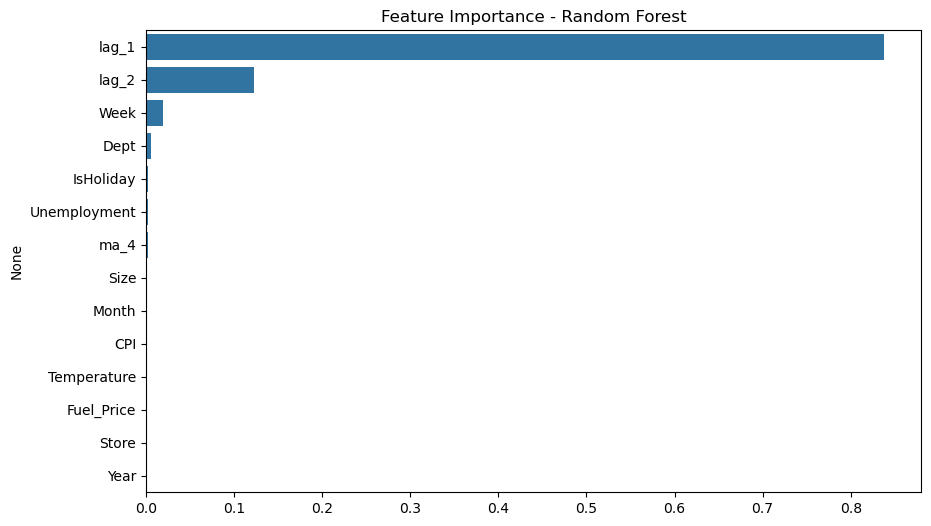

In [43]:
importances = pd.Series(rf.feature_importances_, index=features_cols).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=importances.values, y=importances.index)
plt.title("Feature Importance - Random Forest")
plt.show()

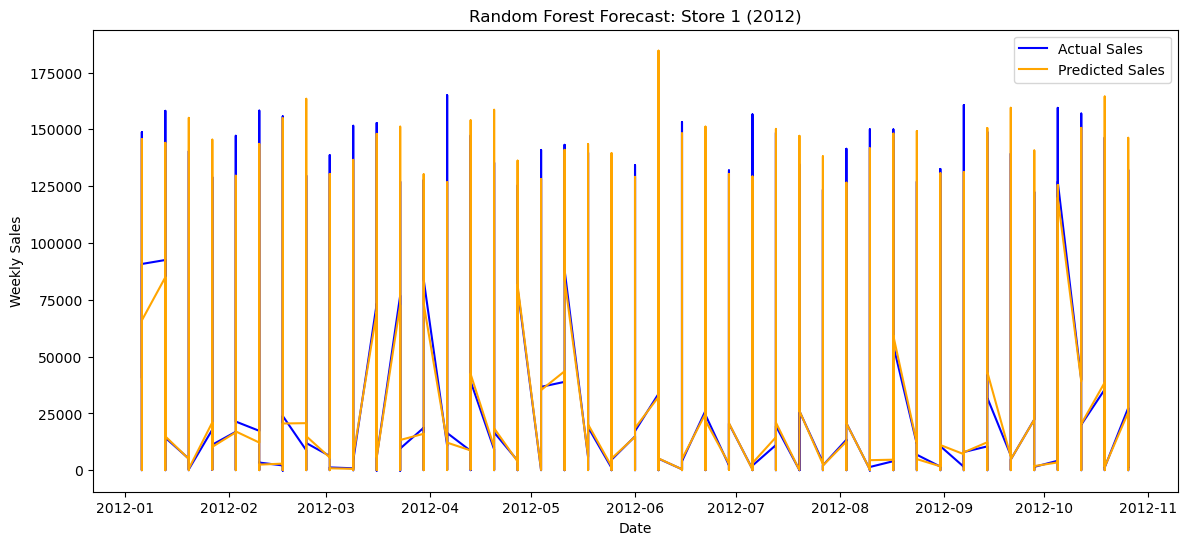

In [44]:
# Example: Store 1 ka test set
sample = test_rf[test_rf["Store"] == 1].copy()
sample["y_pred"] = rf.predict(sample[features_cols])

plt.figure(figsize=(14,6))
plt.plot(sample["Date"], sample["Weekly_Sales"], label="Actual Sales", color="blue")
plt.plot(sample["Date"], sample["y_pred"], label="Predicted Sales", color="orange")
plt.title("Random Forest Forecast: Store 1 (2012)")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend()
plt.show()

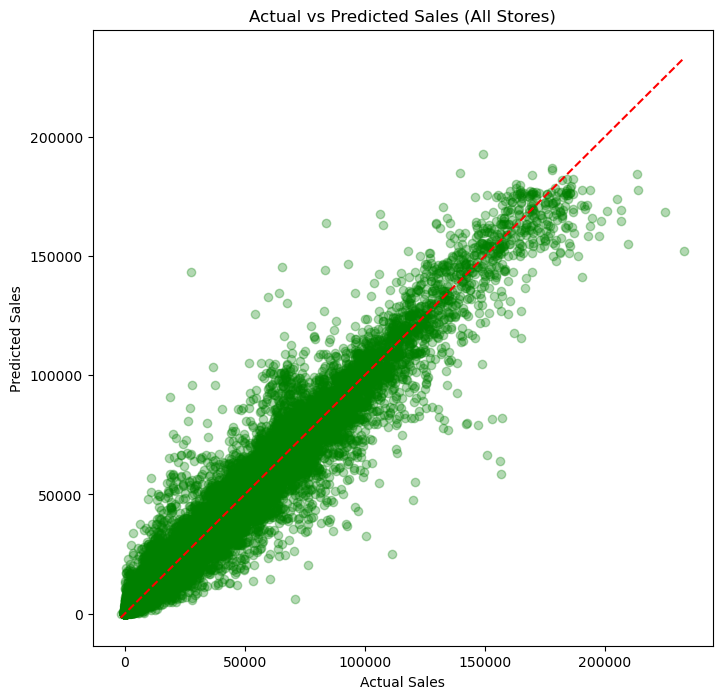

In [46]:
plt.figure(figsize=(8,8))
plt.scatter(y_test, y_pred, alpha=0.3, color="green")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.title("Actual vs Predicted Sales (All Stores)")
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.show()